In [57]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [83]:
full_lumi = luminosity["lep"]["Run2"]
full_lumi = full_lumi/1000
full_lumi

137.64

In [103]:
import uproot
f = uproot.open("FitShapes2.root")

In [104]:
f.keys()

['fail_prefit;1',
 'fail_prefit/CMS_HWW_boosted_qcd_datadriven;1',
 'fail_prefit/TotalBkg;1',
 'fail_prefit/TotalProcs;1',
 'fail_prefit/TotalSig;1',
 'fail_prefit/VBF;1',
 'fail_prefit/VH;1',
 'fail_prefit/data_obs;1',
 'fail_prefit/ggF;1',
 'fail_prefit/singletop;1',
 'fail_prefit/ttH;1',
 'fail_prefit/ttbar;1',
 'fail_prefit/wjets;1',
 'fail_prefit/zjets;1',
 'failBlinded_prefit;1',
 'failBlinded_prefit/CMS_HWW_boosted_qcd_datadriven;1',
 'failBlinded_prefit/TotalBkg;1',
 'failBlinded_prefit/TotalProcs;1',
 'failBlinded_prefit/TotalSig;1',
 'failBlinded_prefit/VBF;1',
 'failBlinded_prefit/VH;1',
 'failBlinded_prefit/data_obs;1',
 'failBlinded_prefit/ggF;1',
 'failBlinded_prefit/singletop;1',
 'failBlinded_prefit/ttH;1',
 'failBlinded_prefit/ttbar;1',
 'failBlinded_prefit/wjets;1',
 'failBlinded_prefit/zjets;1',
 'pass_prefit;1',
 'pass_prefit/CMS_HWW_boosted_qcd_datadriven;1',
 'pass_prefit/TotalBkg;1',
 'pass_prefit/TotalProcs;1',
 'pass_prefit/TotalSig;1',
 'pass_prefit/VBF;1',
 '

In [105]:
f["pass_prefit"].keys()

['CMS_HWW_boosted_qcd_datadriven;1',
 'TotalBkg;1',
 'TotalProcs;1',
 'TotalSig;1',
 'VBF;1',
 'VH;1',
 'data_obs;1',
 'ggF;1',
 'singletop;1',
 'ttH;1',
 'ttbar;1',
 'wjets;1',
 'zjets;1']

In [106]:
samples = [
    "data_obs",
    "TotalBkg",
    "TotalSig",
    "CMS_HWW_boosted_qcd_datadriven",
]

/Users/fmokhtar/miniforge3/envs/coffea-env/lib/python3.9/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: divide by zero encountered in divide
  counts = sumw / scale
/Users/fmokhtar/miniforge3/envs/coffea-env/lib/python3.9/site-packages/mplhep/error_estimation.py:49: RuntimeWarning: invalid value encountered in divide
  counts = sumw / scale


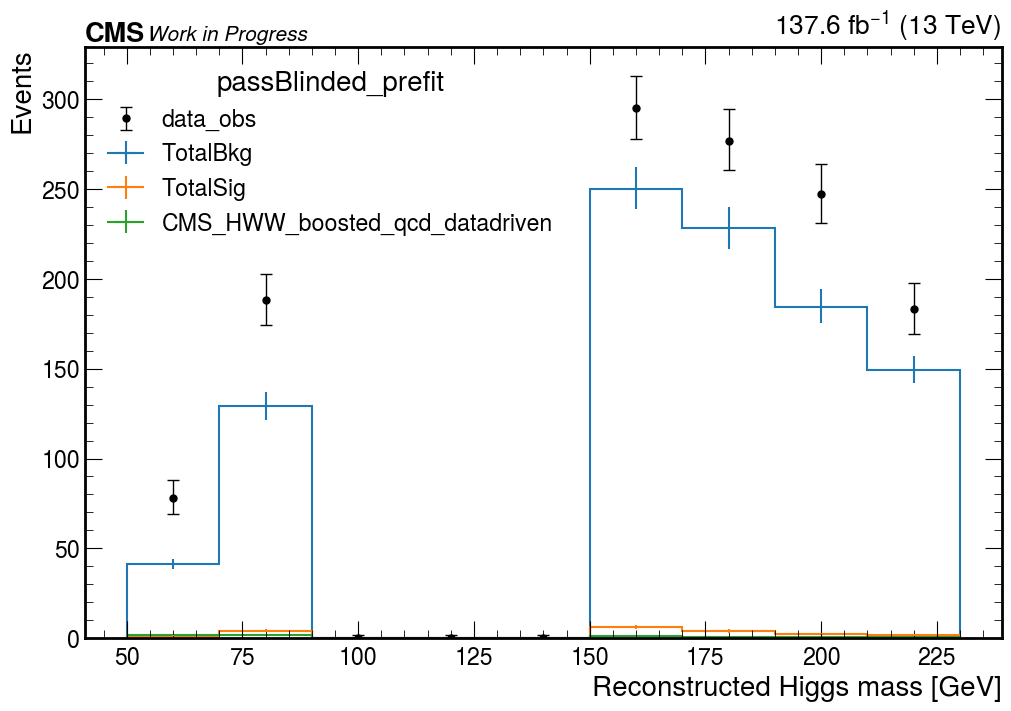

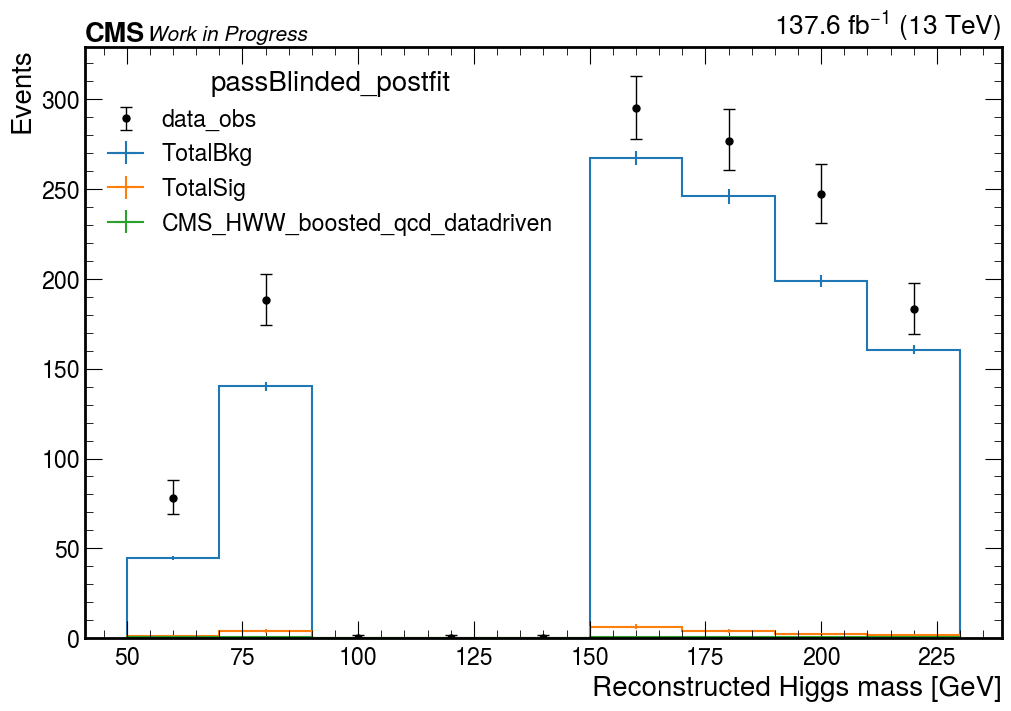

In [107]:
for key in ["passBlinded_prefit", "passBlinded_postfit"]:
    fig, ax = plt.subplots(figsize=(10,7), constrained_layout=True)

    for sample in samples:

        if sample == "data_obs":

            hep.histplot(
                f[key]["data_obs"],
                ax=ax,
                label=sample,
                histtype="errorbar",
                color="k",
                capsize=4,           
            )   

        else:
            hep.histplot(
                f[key][sample],
                ax=ax,
                histtype="step",
                label=sample,
            )    

    ax.legend(title=key)
    ax.set_ylabel(f"Events")
    ax.set_xlabel(f"Reconstructed Higgs mass [GeV]")
    ax.set_ylim(0)    
    hep.cms.lumitext("%.1f " % full_lumi + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20)
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)